In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from bs4 import BeautifulSoup
import requests
import datetime

%matplotlib inline

# Set a dark backgroud
plt.rcParams['figure.facecolor'] = '#191919'

### Read in CA GeoJSON

In [3]:
cali = gpd.read_file('./data/caCountiesNoChannelIslands.geojson')

In [4]:
cali.head()

,COUNTYNS,GEOID,NAME,ALAND,AWATER,geometry
0,00277302,06075,San Francisco,121485107,479107241,"MULTIPOLYGON (((-122.51448 37.78083, -122.5098..."
1,00277320,06111,Ventura,4773302741,946030569,"MULTIPOLYGON (((-119.47784 34.37942, -119.4737..."
2,00277300,06071,San Bernardino,51948123813,123845007,"MULTIPOLYGON (((-117.80254 33.97555, -117.7911..."
3,00277286,06043,Mariposa,3752472156,36225644,"MULTIPOLYGON (((-120.39442 37.67504, -120.3925..."
4,01692767,06103,Tehama,7638228772,33767784,"MULTIPOLYGON (((-123.06543 40.28697, -123.0607..."


### Quick peek at a plot of the GeoJSON

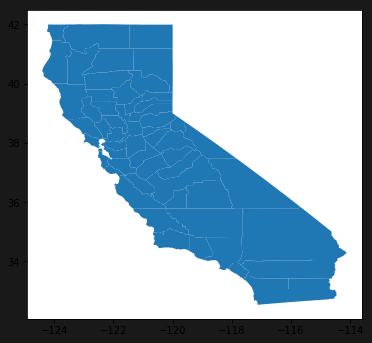

In [5]:
cali.plot(figsize=(6, 6))

### Drop some columns we don't need and set headers to all lowercase

In [6]:
cali = cali.drop(['COUNTYNS', 'GEOID', 'ALAND','AWATER'], axis=1)
cali = cali.rename(str.lower, axis=1)

### Use BeautifulSoup to pull in data from provided URL

In [7]:
# URL to scrape
url = 'http://westnile.ca.gov/case_counts.php?year=2019&option=print'
# Response from url whether it was sucessful or not
response = requests.get(url)
# The actual html of the page
html = response.content
# Parse the html with BeautifulSoup
soup = BeautifulSoup(html,"html.parser")
# Find the table tag in the parsed html
table = soup.find('table')

### Loop over the table and pull out necessary data 

In [8]:
# Empty list to hold extracted row data
list_of_rows = []

# Loop through and find all the 'tr' tags in the table html
for row in table.findAll('tr')[:]:
    # Empty list to hold individual cell data
    list_of_cells = []
    # Loop through and find all the 'td' tags in the table html
    for cell in row.findAll('td'):
        # Replace the unicode charcters with nothing
        text = cell.text.replace('-', '0')
        # Add cleaned up text to empty list_of_cells list
        list_of_cells.append(text)
    # Add the list_of_cells list to the list_of_rows list
    list_of_rows.append(list_of_cells)

### Take a peek at the list_of_rows list of lists

In [9]:
list_of_rows

[['County',
  'Human Cases',
  'Horses',
  'Dead Birds',
  'Mosquito Samples',
  'Sentinel Chickens'],
 ['State Totals', '225', '15', '226', '3288', '139'],
 ['Alameda', '1', '0', '0', '0', '0'],
 ['Alpine', '0', '0', '0', '0', '0'],
 ['Amador', '1', '0', '0', '0', '0'],
 ['Butte', '5', '0', '1', '44', '34'],
 ['Calaveras', '0', '0', '0', '0', '0'],
 ['Colusa', '1', '0', '0', '0', '6'],
 ['Contra Costa', '1', '0', '1', '1', '2'],
 ['Del Norte', '0', '0', '0', '0', '0'],
 ['El Dorado', '0', '0', '0', '0', '0'],
 ['Fresno', '51', '2', '10', '495', '0'],
 ['Glenn', '0', '0', '0', '1', '1'],
 ['Humboldt', '0', '0', '0', '0', '0'],
 ['Imperial', '3', '0', '0', '2', '0'],
 ['Inyo', '0', '0', '0', '0', '0'],
 ['Kern', '28', '2', '2', '128', '0'],
 ['Kings', '3', '0', '0', '63', '0'],
 ['Lake', '0', '0', '0', '6', '0'],
 ['Lassen', '0', '0', '0', '0', '0'],
 ['Los Angeles', '31', '0', '53', '94', '28'],
 ['Madera', '3', '1', '0', '85', '0'],
 ['Marin', '0', '0', '0', '0', '0'],
 ['Mariposa', '

### Create data frame from list

In [10]:
wnv = pd.DataFrame(list_of_rows)

### Make the first row the header row

In [11]:
wnv = wnv.rename(columns=wnv.iloc[0])

### Drop the first index row since we won't need it anymore

In [12]:
wnv = wnv.drop(wnv.index[0])

### Rename columns

In [13]:
wnv.rename(columns={'County' : 'county', 'Human Cases' : 'human', 'Dead Birds' : 'dead birds', 'Mosquito Samples' : 'mosquito', 'Sentinel Chickens' : 'chickens'}, inplace=True)

### Take a look at column types for the data frame

In [14]:
wnv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 1 to 60
Data columns (total 6 columns):
county        60 non-null object
human         60 non-null object
Horses        60 non-null object
dead birds    60 non-null object
mosquito      60 non-null object
chickens      60 non-null object
dtypes: object(6)
memory usage: 3.3+ KB


### Convert case count columns to numeric instead of string

In [15]:
# Convert case count columns to numeric instead of string; using list comprhension
wnv[['human', 'dead birds', 'mosquito', 'chickens']] = pd.concat([wnv[col].astype(int) for col in wnv[['human', 'dead birds', 'mosquito', 'chickens']]],1)

### Make sure column types have changed

In [16]:
wnv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 1 to 60
Data columns (total 6 columns):
county        60 non-null object
human         60 non-null int64
Horses        60 non-null object
dead birds    60 non-null int64
mosquito      60 non-null int64
chickens      60 non-null int64
dtypes: int64(4), object(2)
memory usage: 3.3+ KB


### Output data to csv file

In [17]:
wnv.to_csv('./data/output/wnvData2019.csv', index=False)

### Reproject cali data frame to CA Albers

In [18]:
cali_albers = cali.to_crs('+proj=eqdc +lat_0=36.5 +lat_1=38.43 +lat_2=37.07 +lon_0=-120.5  +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')

### Merge our cali (GeoJSON) and wnv (scraped) data frames

In [19]:
merged_wnv = cali_albers.set_index('name').join(wnv.set_index('county'))

In [20]:
merged_wnv.head()

,geometry,human,Horses,dead birds,mosquito,chickens
Alameda,"MULTIPOLYGON (((-162214.131 146488.103, -16148...",1,0,0,0,0
Alpine,"MULTIPOLYGON (((37199.028 244567.851, 37612.49...",0,0,0,0,0
Amador,"MULTIPOLYGON (((-46005.330 222496.723, -46008....",1,0,0,0,0
Butte,"MULTIPOLYGON (((-134343.948 372111.916, -13418...",5,0,1,44,34
Calaveras,"MULTIPOLYGON (((-43218.769 191626.785, -43045....",0,0,0,0,0


### Create a point data frame from our merged_wnv data frame which will be used to create bubble markers on a map.
### We'll use a function to do this so we can use it later on for other data frames instead of having to type out the two commands each time

In [21]:
def createPointDf(df):
    copy_df = df.copy()
    copy_df["geometry"] = copy_df.centroid
    return copy_df

In [22]:
merged_wnv_pt = createPointDf(merged_wnv)

### Create our map

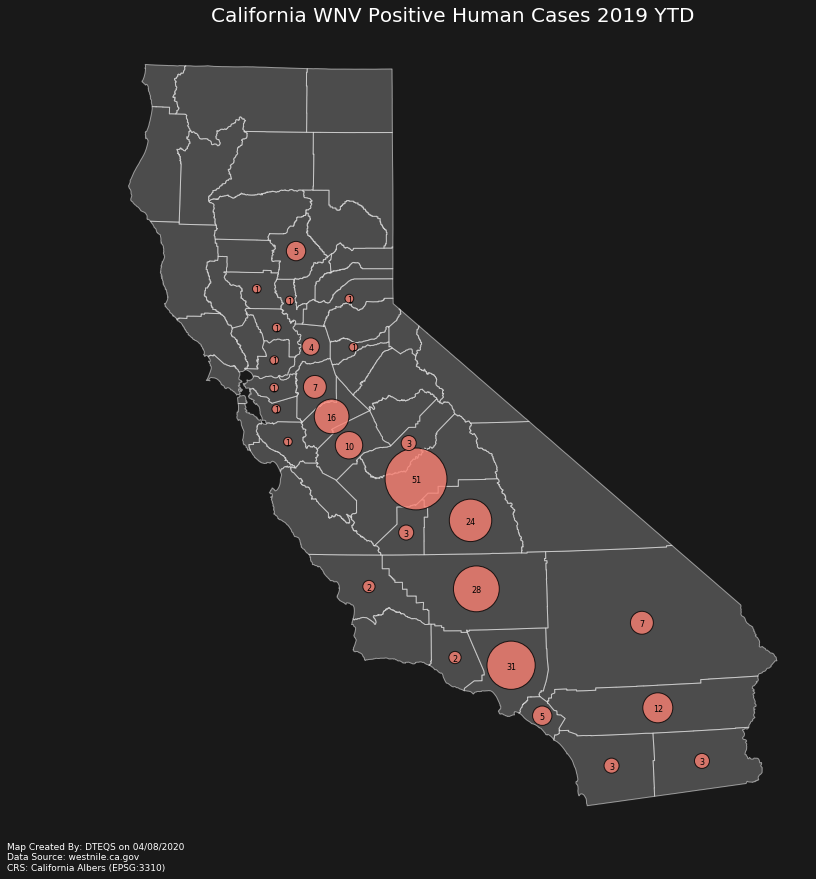

In [23]:
# Empty list to hold labels for bubble markers
markerLabels =[]

# Base map of CA
basemap = cali_albers.plot(figsize=(15,15), color= 'grey', edgecolor='white', alpha=0.5)

# Add human cases to map as circles 
bubble_map = merged_wnv_pt.plot(ax = basemap, markersize = (merged_wnv['human'] * 75) , color = "salmon", edgecolor = "black", alpha = 0.8, label='WNV Human Cases')

# Turn off axis
basemap.set_axis_off()

# Title For Map
plt.title('California WNV Positive Human Cases 2019 YTD' , fontsize=20, color='white');
plt.figtext(0.1, 0.1, 'Map Created By: DTEQS on ' + datetime.datetime.now().strftime('%m/%d/%Y') + '\nData Source: westnile.ca.gov' + '\n' + 'CRS: California Albers (EPSG:3310)', fontsize=9, 
            color='white')

# Use zip to iterate over the x/y of geometry and the pediatric column
for x, y, label in zip(merged_wnv_pt.geometry.x, merged_wnv_pt.geometry.y, merged_wnv_pt['human']):
    if label != 0:
        markerLabels.append(plt.text(x,y,label, fontsize=8, horizontalalignment='center', verticalalignment='center_baseline'))

In [25]:
# Save to png
outdir = './data/output/'
fig = basemap.get_figure()
fig.savefig(outdir + 'pandas_wnvHumanBubble2019.png', format='png', dpi=700, facecolor=fig.get_facecolor())